# Модель Ensemble 
* Идея ансамблевой модели заключается в том, что на каждом чанке с обработанными данными обучается одна модель, записывается в список, а предсказание делается методом усреднения или голосования.

## Импорт необходимых библиотек и модулей

In [1]:
import os
import dill
import itertools
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import torch
import torch.nn.functional as F

from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Подготовка классов из pytorch:

In [2]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]

In [3]:
 class ClassificationNet(nn.Module):
    def __init__(self, feature_input):
        super().__init__()
        
        self.hidden1 = nn.Linear(feature_input, 256)
        self.f1 = nn.Sigmoid()
        self.hidden2 = nn.Linear(256, 10)
        self.f2 = nn.Sigmoid()
        self.output = nn.Linear(10, 1)
        self.f3 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.f1(self.hidden1(x))
        x = self.f2(self.hidden2(x))
        x = self.f3(self.output(x))
        
        return x

In [4]:
class EnsembleNet(object):
    """
    Ансамблевая модель машинного обучения построенная на основе моделей
    нейронных сетей из пакета PyTorch. Каждая модель обучается на
    отдельном чанке с предобработанными данными.

    Parameters
    ----------
    learning_rate : float, default=1e-3
        Множитель перед градиентом.

    batch_size : int, default=1024
        Определяет размер батча класса DataLoader.

    num_epochs : int, default=10
        Число эпох обучения.

    train_size : float, default=0.8
        Доля обучающей выборки от датафрейма.

    verbose : bool, default=True
        Вывод подробной информации в процессе обучения.

    Attributes
    ----------

    models : list
        Список обученных моделей.

    features : list
        Хранит список признаков для каждой модели.

    loss_test : list
        Список со списком значений функции потерь
        для каждой модели.

    roc_auc_test : list
        Список со списком значений метрики
        для каждой модели.
    """

    def __init__(
            self,
            learning_rate=1e-3,
            batch_size=1024,
            num_epochs=10,
            train_size=0.8,
            verbose=True
    ):
        self.models = []
        self.features = []
        self.loss_test = []
        self.roc_auc_test = []
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.train_size = train_size
        self.verbose = verbose

    def fit(self, path_train, classes_weights=False):
        """
        Для каждого файла с данными в path_train обучает одну модель
        и записывает в список моделей self.models.

        Parameters
        ----------
        path_train : str
            Путь до директории с обучающей выборкой.

        classes_weights : bool, default=False
            Флаг для весов классов.

        Returns
        -------
        self
            Обученная ансамблевая модель.
        """

        self.models = []
        self.features = []
        self.loss_test = []
        self.roc_auc_test = []

        chunk_paths = sorted([
            os.path.join(path_train, filename)
            for filename in os.listdir(path_train)
            if filename.startswith('processed')
        ])
        for i, chunk in enumerate(chunk_paths):
            # объявим список ошибок и для текущей модели
            loss_test = []
            roc_auc_test = []

            # загружаем данные и разделяем на трейн и тест
            data = pd.read_parquet(chunk)
            X = data.drop(['id', 'flag'], axis=1).to_numpy()
            y = data['flag'].to_numpy()
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=self.train_size, random_state=42,
                                                                stratify=y)
            self.features.append(list(data.drop(['id', 'flag'], axis=1).columns))
            del data

            # считаем веса классов
            class_weights = None
            if classes_weights:
                class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                                  classes=np.unique(y_train),
                                                                  y=y_train)
                class_weights = torch.tensor(class_weights, dtype=torch.float)

            # выбираем вычислительный блок
            device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

            # объявляем датасет
            train_dataset = MyDataset(X_train, y_train)
            X_test_tensor = torch.from_numpy(X_test.astype(np.float32)).to(device)
            y_test_tensor = torch.from_numpy(y_test.astype(np.float32)).to(device)

            # объявляем даталоадер
            train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)

            # инициализируем модель
            self.models.append(ClassificationNet(feature_input=X.shape[1]))
            self.models[-1].to(device)
            optimizer = torch.optim.Adam(self.models[-1].parameters(), lr=self.learning_rate)
            if self.verbose:
                print(f'Start train model {i + 1}')

            for epoch in range(self.num_epochs):
                for X, y in train_dataloader:

                    # отправляем батчи на cpu или gpu
                    X, y = X.to(device), y.to(device)

                    # делаем предикт
                    pred = self.models[-1](X)

                    # вычисляем веса классов
                    if classes_weights:
                        weights = torch.zeros_like(y.unsqueeze(-1))
                        weights[y == 0] = class_weights[0]
                        weights[y == 1] = class_weights[1]
                    else:
                        weights = None

                    # делаем шаг градиентного спуска
                    loss = F.binary_cross_entropy(pred, y.unsqueeze(-1), weight=weights)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                with torch.no_grad():
                    # вычисляем веса классов
                    if classes_weights:
                        weights = torch.zeros_like(y_test_tensor.unsqueeze(-1))
                        weights[y_test_tensor == 0] = class_weights[0]
                        weights[y_test_tensor == 1] = class_weights[1]
                    else:
                        weights = None

                    # считаем потери на тесте
                    loss = F.binary_cross_entropy(self.models[-1](X_test_tensor), y_test_tensor.unsqueeze(-1),
                                                  weight=weights).item()

                    # вычисляем значение метрики auc
                    fpr, tpr, _ = roc_curve(y_test, self.models[-1](X_test_tensor).cpu().detach().numpy().ravel())
                    roc_auc = auc(fpr, tpr)
                    loss_test.append(loss)
                    roc_auc_test.append(roc_auc)
                    if self.verbose:
                        print(f'epoch {epoch + 1:3.0f} | loss {loss:0.5f} | roc_auc {roc_auc:0.5f}')

            self.loss_test.append(loss_test)
            self.roc_auc_test.append(roc_auc_test)
            if self.verbose:
                print(f'Finish train model {i + 1}\n')

    def predict(self, X, method='mean', path_to_model=None):
        """
        Делает предсказание классов. Если модели не загружены, 
        можно указать путь к файлу .pt.
        """
        if len(self.models) == 0:
            if path_to_model is None:
                raise BaseException('no models were fitted or loaded')
            else:
                self.load_model(path_to_model)

        y_list = []
        for features, model in zip(self.features, self.models):
            X_df = pd.DataFrame(X, columns=features).fillna(0.)
            X_tensor = torch.from_numpy(X_df.to_numpy().astype(np.float32))
            y = model(X_tensor).detach().numpy().ravel()
            y_list.append(y)

        y = np.array(y_list).T

        if method == 'mean':
            return np.round(pd.DataFrame(y).mean(axis=1).to_numpy())
        elif method == 'vote':
            return pd.DataFrame(np.round(y)).mode(axis=1)[0].squeeze().to_numpy()
        else:
            raise BaseException('unknown method given')


    def predict_proba(self, X, path_to_model=None):
        """
        Делает предсказание вероятностей классов. 
        Если модели не загружены, можно указать путь к файлу .pt.
        """
        if len(self.models) == 0:
            if path_to_model is None:
                raise BaseException('no models were fitted or loaded')
            else:
                self.load_model(path_to_model)

        y_list = []
        for features, model in zip(self.features, self.models):
            X_df = pd.DataFrame(X, columns=features).fillna(0.)
            X_tensor = torch.from_numpy(X_df.to_numpy().astype(np.float32))
            y = model(X_tensor).detach().numpy().ravel()
            y_list.append(y)

        y = np.array(y_list).T
        return pd.DataFrame(y).mean(axis=1).to_numpy()

    def save_model(self, path_to_model='../data/ensemble_models/'):
        if not os.path.exists(path_to_model):
            os.makedirs(path_to_model)

        models_to_save = []
        for model, features in zip(self.models, self.features):
            models_to_save.append({
                'state_dict': model.state_dict(),
                'features': features
            })

        torch.save(models_to_save, os.path.join(
            path_to_model, f'ensemblemodel_{datetime.now().strftime("%Y%m%d%H%M")}.pt'
        ))

        
    def load_model(self, path_to_model):
        checkpoint = torch.load(path_to_model, map_location=torch.device('cpu'))
        self.models = []
        self.features = []

        for m in checkpoint:
            model = ClassificationNet(feature_input=len(m['features']))
            model.load_state_dict(m['state_dict'])
            model.eval()
            self.models.append(model)
            self.features.append(m['features'])

        if self.verbose:
            print(f'✅ Загружено моделей: {len(self.models)} из {path_to_model}')

        return self

## Определяем функцию confusion_matrix

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Определяем модель с гиперпараметрами:
* learning_rate - скорость обучения,
* batch_size - количество примеров, обрабатываемых за один шаг оптимизации,
* num_epochs - количество эпох (проходов по всему обучающему набору данных)

In [6]:
ensemble = EnsembleNet(learning_rate=1e-3, batch_size=1024, num_epochs=10)

## Обучаем модель

In [7]:
ensemble.fit(path_train='/home/jupyter/project/processed_data_1/train', classes_weights=True)

Start train model 1
epoch   1 | loss 0.61177 | roc_auc 0.73311
epoch   2 | loss 0.59635 | roc_auc 0.74943
epoch   3 | loss 0.58989 | roc_auc 0.75610
epoch   4 | loss 0.58702 | roc_auc 0.75913
epoch   5 | loss 0.58552 | roc_auc 0.76082
epoch   6 | loss 0.58493 | roc_auc 0.76174
epoch   7 | loss 0.58426 | roc_auc 0.76227
epoch   8 | loss 0.58466 | roc_auc 0.76231
epoch   9 | loss 0.58465 | roc_auc 0.76260
epoch  10 | loss 0.58452 | roc_auc 0.76280
Finish train model 1

Start train model 2
epoch   1 | loss 0.59809 | roc_auc 0.75247
epoch   2 | loss 0.58388 | roc_auc 0.76639
epoch   3 | loss 0.57804 | roc_auc 0.77154
epoch   4 | loss 0.57482 | roc_auc 0.77377
epoch   5 | loss 0.57309 | roc_auc 0.77484
epoch   6 | loss 0.57221 | roc_auc 0.77541
epoch   7 | loss 0.57194 | roc_auc 0.77571
epoch   8 | loss 0.57165 | roc_auc 0.77587
epoch   9 | loss 0.57135 | roc_auc 0.77601
epoch  10 | loss 0.57080 | roc_auc 0.77616
Finish train model 2

Start train model 3
epoch   1 | loss 0.59858 | roc_auc 0

## Сохраняем модель и строим графики функции потерь и метрики auc для каждой модели в ансамбле

In [8]:
ensemble.save_model(path_to_model='/home/jupyter/project/ensemble')

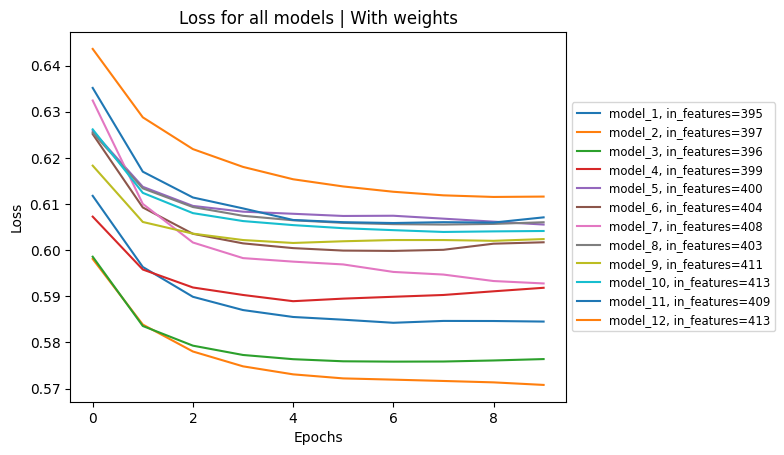

In [9]:
plt.plot(np.array(ensemble.loss_test).T)
plt.title('Loss for all models | With weights')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend([f'model_{i+1}, in_features={len(feature)}' for i, feature in enumerate(ensemble.features)], 
           loc='center left', 
           bbox_to_anchor=(1, 0.5), 
           fontsize='small')
plt.savefig('/home/jupyter/project/Ensemble_model.png', bbox_inches='tight');

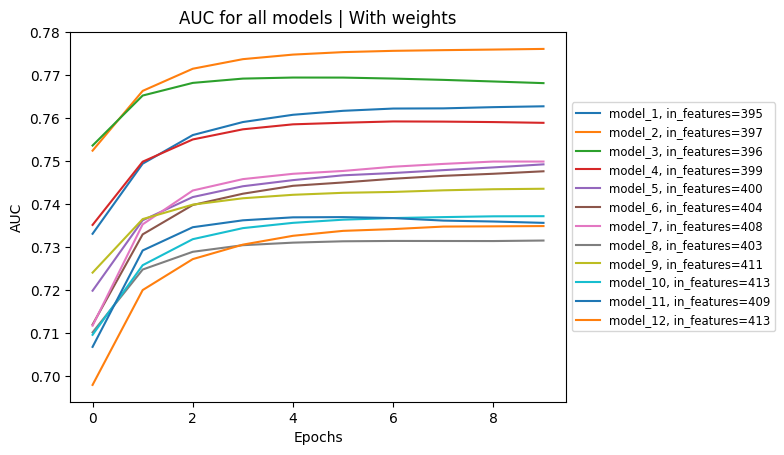

In [10]:
plt.plot(np.array(ensemble.roc_auc_test).T)
plt.title('AUC for all models | With weights')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend([f'model_{i+1}, in_features={len(feature)}' for i, feature in enumerate(ensemble.features)], 
           loc='center left', 
           bbox_to_anchor=(1, 0.5), 
           fontsize='small')
plt.savefig('/home/jupyter/project/Ensemble_model_1.png', bbox_inches='tight');

## Загружаем тестовый набор данных

In [8]:
data = pd.read_parquet('/home/jupyter/project/processed_data_1/test/test.parquet')
data.head()

,id,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,...,paym_bad_count_24,paym_bad_count_25,paym_last_status_1,paym_last_status_2,paym_last_status_3,is_active_loan_1,flag,pre_loans5_1,pre_loans530_19,pre_loans3060_2,pre_loans6090_3,pre_loans90_8,total_past_dues_21,total_past_dues_51,pre_loans5_9,total_past_dues_31,pre_loans5_8,pre_loans90_10,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_1,enc_loans_credit_type_6,enc_loans_credit_type_7,has_current_overdue_1,pre_loans5_11,pre_loans3060_1,pre_loans3060_3,pre_loans90_3,total_past_dues_58,total_past_dues_59,pre_loans3060_4,pre_loans3060_6,pre_loans6090_1,total_past_dues_54,total_past_dues_55,total_past_dues_57,pre_loans5_10,pre_loans530_5,pre_loans530_8,pre_loans530_9,pre_loans530_17
1679350,1679350,4,4,4,4,4,2,4,4,1,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,4.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385353,385353,6,6,6,6,6,3,6,6,2,3,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2137282,2137282,9,4,4,6,5,4,7,7,1,5,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,2.0,5.0,0,0.0,0.0,0.0,0.0,10.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
896053,896053,8,8,11,13,12,10,12,7,3,4,3.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,...,2.0,0.0,2.0,0.0,1.0,9.0,0,0.0,0.0,0.0,0.0,13.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2824317,2824317,4,4,4,4,4,1,4,4,2,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN


## Сделаем предсказания методом усреднения

In [10]:
MODEL_PATH = '/home/jupyter/project/ensemble/ensemblemodel_202511061805.pt'# путь до рабочей модели
X = data.drop(['id', 'flag'], axis=1)
y_test = data['flag']
y_pred = ensemble.predict(X, path_to_model=MODEL_PATH)

✅ Загружено моделей: 12 из /home/jupyter/project/ensemble/ensemblemodel_202511061805.pt


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81    578712
           1       0.08      0.69      0.14     21288

    accuracy                           0.69    600000
   macro avg       0.53      0.69      0.47    600000
weighted avg       0.95      0.69      0.79    600000



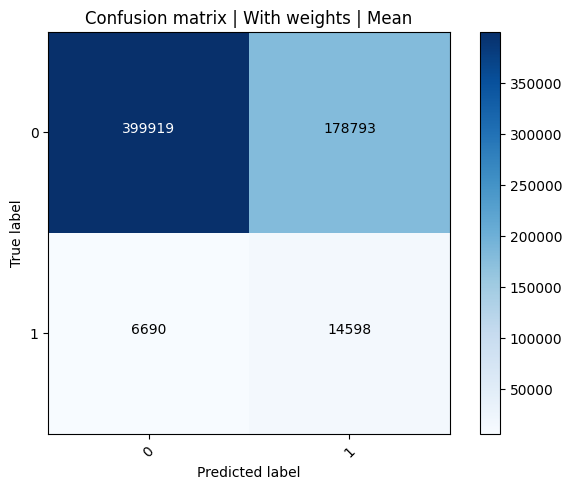

In [14]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='Confusion matrix | With weights | Mean')
plt.savefig('/home/jupyter/project/Ensemble_model_2.png', bbox_inches='tight');

## Сделаем предсказания методом голосования

In [15]:
y_test = data['flag']
y_pred = ensemble.predict(X, method='vote')

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82    578712
           1       0.08      0.68      0.14     21288

    accuracy                           0.70    600000
   macro avg       0.53      0.69      0.48    600000
weighted avg       0.95      0.70      0.79    600000



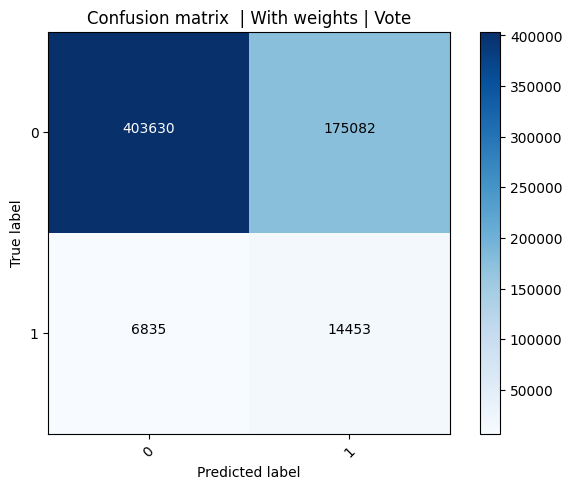

In [17]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='Confusion matrix  | With weights | Vote')
plt.savefig('/home/jupyter/project/Ensemble_model_3.png', bbox_inches='tight');

## Посчитаем значение метрики AUC и построим ROC кривую

🎯 ROC-AUC:         0.7562


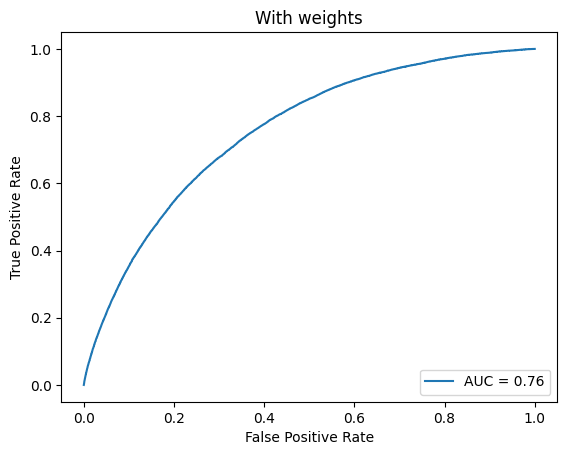

In [18]:
y_pred_proba = ensemble.predict_proba(X)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"🎯 ROC-AUC:       {roc_auc:>8.4f}")

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('With weights')
plt.savefig('/home/jupyter/project/Ensemble_model_4.png', bbox_inches='tight');

# На методе Mean recall незначительно лучше на положительном классе что нам важно. Значение ROC-AUC: 0.7562 что является для нас положительным результатом, но у CatBoost получше.